### Libs

In [46]:
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR
from scipy.signal import correlate
from statsmodels.graphics.tsaplots import plot_acf
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Data

In [35]:
training_data = pd.read_csv('data_t.csv', index_col='openTime')

In [36]:
train_columns = []
test_columns = []

for col in training_data.columns:
    if "_ret" in col:
        test_columns.append(col)
    else:
        train_columns.append(col)

### Preparing

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [58]:
window_size = 100

all_x = np.lib.stride_tricks.sliding_window_view(training_data.values, (window_size, training_data.shape[1]))[:, 0]
all_y = training_data[test_columns].iloc[99:]

In [61]:
n_samples = len(all_x)

train_end = int(n_samples * 0.7)
val_end = int(n_samples * (0.7 + 0.15))

#тестовый
x_test = all_x[val_end:].view()
y_test = all_y[val_end:].values.view()

#для train/val
x_temp = all_x[:val_end]
y_temp = all_y[:val_end]
temp_samples = len(x_temp)

val_start = int(temp_samples * (0.7 / (0.7 + 0.15)))

#val с буфером
val_start_buf = max(0, val_start - 120)
val_end_buf = min(temp_samples, val_start + int(temp_samples * 0.15 / (0.7 + 0.15)) + 120)

x_val = x_temp[val_start_buf:val_end_buf].view()
y_val = y_temp[val_start_buf:val_end_buf].values.view()


x_train_part1 = x_temp[:max(0, val_start_buf - 120)]
y_train_part1 = y_temp[:max(0, val_start_buf - 120)]

x_train_part2 = x_temp[min(temp_samples, val_end_buf + 120):]
y_train_part2 = y_temp[min(temp_samples, val_end_buf + 120):]

x_train = np.concatenate([x_train_part1, x_train_part2], axis=0) if len(x_train_part2) > 0 else x_train_part1
y_train = np.concatenate([y_train_part1, y_train_part2], axis=0) if len(y_train_part2) > 0 else y_train_part1

x_train=x_train.view()
y_train=y_train.values.view()

print(f"Train: {x_train.shape}, val: {x_val.shape}, test: {x_test.shape}")
print(f"y train: {y_train.shape}, y val: {y_val.shape}, y test: {y_test.shape}")

Train: (2730, 100, 891), val: (757, 100, 891), test: (637, 100, 891)
y train: (2730, 99), y val: (757, 99), y test: (637, 99)


### Tensors

In [ ]:
def clean_data(arr):
    arr = np.where(np.isinf(arr), np.nan, arr)
    col_means = np.nanmean(arr, axis=(0, 1)) if arr.ndim == 3 else np.nanmean(arr, axis=0)
    arr = np.where(np.isnan(arr), col_means, arr)
    return arr

x_train = clean_data(x_train)
x_val = clean_data(x_val)
x_test = clean_data(x_test)
y_train = clean_data(y_train)
y_val = clean_data(y_val)
y_test = clean_data(y_test)

In [ ]:
scaler_X = StandardScaler()
x_train = scaler_X.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_val = scaler_X.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
x_test = scaler_X.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

In [64]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

### Models

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(MLPModel, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.1))
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

### Learning

In [ ]:
# Параметры
input_size = x_train.shape[1] * x_train.shape[2] 
hidden_size = 256
output_size = y_train.shape[1] 
num_layers = 2
batch_size = 32
num_epochs = 50
learning_rate = 0.001
alpha = 0.5

model = MLPModel(input_size, hidden_size, output_size, num_layers).to(device)

criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)


train_losses = []
val_losses = []
train_mse_list = []
train_mae_list = []
val_mse_list = []
val_mae_list = []


for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    train_mse = 0.0
    train_mae = 0.0
    train_batches = 0
    
    for X_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        X_batch = X_batch.view(X_batch.size(0), -1)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        
        loss_mse = criterion_mse(outputs, y_batch)
        loss_mae = criterion_mae(outputs, y_batch)
        loss = loss_mse + alpha * loss_mae
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_mse += loss_mse.item()
        train_mae += loss_mae.item()
        train_batches += 1
    
    model.eval()
    val_loss = 0.0
    val_mse = 0.0
    val_mae = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            X_batch = X_batch.view(X_batch.size(0), -1)
            
            outputs = model(X_batch)
            
            loss_mse = criterion_mse(outputs, y_batch)
            loss_mae = criterion_mae(outputs, y_batch)
            loss = loss_mse + alpha * loss_mae
            
            val_loss += loss.item()
            val_mse += loss_mse.item()
            val_mae += loss_mae.item()
            val_batches += 1
    
    train_loss /= train_batches
    train_mse /= train_batches
    train_mae /= train_batches
    val_loss /= val_batches
    val_mse /= val_batches
    val_mae /= val_batches
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_mse_list.append(train_mse)
    train_mae_list.append(train_mae)
    val_mse_list.append(val_mse)
    val_mae_list.append(val_mae)
    
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train loss: {train_loss:.6f}, MSE: {train_mse:.6f}, MAE: {train_mae:.6f}')
    print(f'Val loss: {val_loss:.6f}, MSE: {val_mse:.6f}, MAE: {val_mae:.6f}')
    print(f'LR: {scheduler.get_last_lr()[0]:.6f}')


Epoch 1/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/50:
  Train - Loss: 2.807428, MSE: 2.350147, MAE: 0.914563
  Val   - Loss: 0.878178, MSE: 0.620880, MAE: 0.514595
  LR: 0.001000
--------------------------------------------------


Epoch 2/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/50:
  Train - Loss: 1.340077, MSE: 1.003046, MAE: 0.674063
  Val   - Loss: 0.877608, MSE: 0.620481, MAE: 0.514254
  LR: 0.001000
--------------------------------------------------


Epoch 3/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/50:
  Train - Loss: 1.324096, MSE: 0.989625, MAE: 0.668941
  Val   - Loss: 0.877141, MSE: 0.620143, MAE: 0.513997
  LR: 0.001000
--------------------------------------------------


Epoch 4/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/50:
  Train - Loss: 1.306363, MSE: 0.975078, MAE: 0.662570
  Val   - Loss: 0.876589, MSE: 0.619717, MAE: 0.513744
  LR: 0.001000
--------------------------------------------------


Epoch 5/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/50:
  Train - Loss: 1.245894, MSE: 0.924133, MAE: 0.643521
  Val   - Loss: 0.876225, MSE: 0.619395, MAE: 0.513660
  LR: 0.001000
--------------------------------------------------


Epoch 6/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/50:
  Train - Loss: 1.184779, MSE: 0.870896, MAE: 0.627767
  Val   - Loss: 0.876305, MSE: 0.619491, MAE: 0.513629
  LR: 0.001000
--------------------------------------------------


Epoch 7/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/50:
  Train - Loss: 1.101856, MSE: 0.804064, MAE: 0.595583
  Val   - Loss: 0.875024, MSE: 0.618346, MAE: 0.513356
  LR: 0.001000
--------------------------------------------------


Epoch 8/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/50:
  Train - Loss: 0.992119, MSE: 0.715709, MAE: 0.552821
  Val   - Loss: 0.857267, MSE: 0.602558, MAE: 0.509419
  LR: 0.001000
--------------------------------------------------


Epoch 9/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/50:
  Train - Loss: 0.850541, MSE: 0.601706, MAE: 0.497671
  Val   - Loss: 0.669606, MSE: 0.449169, MAE: 0.440872
  LR: 0.001000
--------------------------------------------------


Epoch 10/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/50:
  Train - Loss: 0.774812, MSE: 0.545074, MAE: 0.459475
  Val   - Loss: 0.544413, MSE: 0.354900, MAE: 0.379026
  LR: 0.000500
--------------------------------------------------


Epoch 11/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11/50:
  Train - Loss: 0.703222, MSE: 0.491953, MAE: 0.422537
  Val   - Loss: 0.509354, MSE: 0.333639, MAE: 0.351431
  LR: 0.000500
--------------------------------------------------


Epoch 12/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12/50:
  Train - Loss: 0.703417, MSE: 0.494143, MAE: 0.418550
  Val   - Loss: 0.525301, MSE: 0.344803, MAE: 0.360996
  LR: 0.000500
--------------------------------------------------


Epoch 13/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13/50:
  Train - Loss: 0.690060, MSE: 0.484023, MAE: 0.412072
  Val   - Loss: 0.515777, MSE: 0.338028, MAE: 0.355498
  LR: 0.000500
--------------------------------------------------


Epoch 14/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14/50:
  Train - Loss: 0.683052, MSE: 0.481487, MAE: 0.403130
  Val   - Loss: 0.500510, MSE: 0.327621, MAE: 0.345779
  LR: 0.000500
--------------------------------------------------


Epoch 15/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15/50:
  Train - Loss: 0.682075, MSE: 0.479530, MAE: 0.405091
  Val   - Loss: 0.504614, MSE: 0.330701, MAE: 0.347827
  LR: 0.000500
--------------------------------------------------


Epoch 16/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16/50:
  Train - Loss: 0.674299, MSE: 0.472006, MAE: 0.404587
  Val   - Loss: 0.499223, MSE: 0.325980, MAE: 0.346486
  LR: 0.000500
--------------------------------------------------


Epoch 17/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17/50:
  Train - Loss: 0.668592, MSE: 0.467449, MAE: 0.402287
  Val   - Loss: 0.500947, MSE: 0.328367, MAE: 0.345160
  LR: 0.000500
--------------------------------------------------


Epoch 18/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18/50:
  Train - Loss: 0.665803, MSE: 0.465700, MAE: 0.400206
  Val   - Loss: 0.525338, MSE: 0.342598, MAE: 0.365481
  LR: 0.000500
--------------------------------------------------


Epoch 19/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19/50:
  Train - Loss: 0.668322, MSE: 0.466867, MAE: 0.402910
  Val   - Loss: 0.507807, MSE: 0.332948, MAE: 0.349718
  LR: 0.000500
--------------------------------------------------


Epoch 20/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20/50:
  Train - Loss: 0.669343, MSE: 0.469627, MAE: 0.399433
  Val   - Loss: 0.496761, MSE: 0.324647, MAE: 0.344229
  LR: 0.000250
--------------------------------------------------


Epoch 21/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21/50:
  Train - Loss: 0.674962, MSE: 0.474855, MAE: 0.400214
  Val   - Loss: 0.490748, MSE: 0.320296, MAE: 0.340904
  LR: 0.000250
--------------------------------------------------


Epoch 22/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22/50:
  Train - Loss: 0.652113, MSE: 0.455657, MAE: 0.392912
  Val   - Loss: 0.492949, MSE: 0.321696, MAE: 0.342507
  LR: 0.000250
--------------------------------------------------


Epoch 23/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23/50:
  Train - Loss: 0.662874, MSE: 0.465673, MAE: 0.394401
  Val   - Loss: 0.487641, MSE: 0.318874, MAE: 0.337533
  LR: 0.000250
--------------------------------------------------


Epoch 24/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24/50:
  Train - Loss: 0.663539, MSE: 0.466687, MAE: 0.393703
  Val   - Loss: 0.494830, MSE: 0.322308, MAE: 0.345044
  LR: 0.000250
--------------------------------------------------


Epoch 25/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25/50:
  Train - Loss: 0.675950, MSE: 0.477071, MAE: 0.397759
  Val   - Loss: 0.497610, MSE: 0.325586, MAE: 0.344047
  LR: 0.000250
--------------------------------------------------


Epoch 26/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26/50:
  Train - Loss: 0.653993, MSE: 0.457038, MAE: 0.393910
  Val   - Loss: 0.492541, MSE: 0.322565, MAE: 0.339952
  LR: 0.000250
--------------------------------------------------


Epoch 27/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27/50:
  Train - Loss: 0.651774, MSE: 0.455871, MAE: 0.391804
  Val   - Loss: 0.489113, MSE: 0.319835, MAE: 0.338556
  LR: 0.000250
--------------------------------------------------


Epoch 28/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28/50:
  Train - Loss: 0.653431, MSE: 0.458398, MAE: 0.390066
  Val   - Loss: 0.490229, MSE: 0.320321, MAE: 0.339815
  LR: 0.000250
--------------------------------------------------


Epoch 29/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29/50:
  Train - Loss: 0.663070, MSE: 0.465594, MAE: 0.394952
  Val   - Loss: 0.489824, MSE: 0.319899, MAE: 0.339850
  LR: 0.000250
--------------------------------------------------


Epoch 30/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30/50:
  Train - Loss: 0.649979, MSE: 0.454094, MAE: 0.391768
  Val   - Loss: 0.482247, MSE: 0.314997, MAE: 0.334499
  LR: 0.000125
--------------------------------------------------


Epoch 31/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31/50:
  Train - Loss: 0.662259, MSE: 0.465174, MAE: 0.394170
  Val   - Loss: 0.488031, MSE: 0.319019, MAE: 0.338024
  LR: 0.000125
--------------------------------------------------


Epoch 32/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32/50:
  Train - Loss: 0.637361, MSE: 0.443589, MAE: 0.387544
  Val   - Loss: 0.483246, MSE: 0.315445, MAE: 0.335603
  LR: 0.000125
--------------------------------------------------


Epoch 33/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33/50:
  Train - Loss: 0.656225, MSE: 0.460442, MAE: 0.391566
  Val   - Loss: 0.486731, MSE: 0.317814, MAE: 0.337834
  LR: 0.000125
--------------------------------------------------


Epoch 34/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34/50:
  Train - Loss: 0.656867, MSE: 0.460589, MAE: 0.392557
  Val   - Loss: 0.480832, MSE: 0.313022, MAE: 0.335621
  LR: 0.000125
--------------------------------------------------


Epoch 35/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35/50:
  Train - Loss: 0.658186, MSE: 0.461122, MAE: 0.394129
  Val   - Loss: 0.486490, MSE: 0.317847, MAE: 0.337286
  LR: 0.000125
--------------------------------------------------


Epoch 36/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36/50:
  Train - Loss: 0.644393, MSE: 0.450162, MAE: 0.388461
  Val   - Loss: 0.488115, MSE: 0.318444, MAE: 0.339343
  LR: 0.000125
--------------------------------------------------


Epoch 37/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37/50:
  Train - Loss: 0.663654, MSE: 0.467063, MAE: 0.393182
  Val   - Loss: 0.482266, MSE: 0.314936, MAE: 0.334661
  LR: 0.000125
--------------------------------------------------


Epoch 38/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38/50:
  Train - Loss: 0.627881, MSE: 0.436538, MAE: 0.382687
  Val   - Loss: 0.486312, MSE: 0.317048, MAE: 0.338528
  LR: 0.000125
--------------------------------------------------


Epoch 39/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39/50:
  Train - Loss: 0.650048, MSE: 0.454722, MAE: 0.390652
  Val   - Loss: 0.485627, MSE: 0.316981, MAE: 0.337292
  LR: 0.000125
--------------------------------------------------


Epoch 40/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40/50:
  Train - Loss: 0.649465, MSE: 0.453764, MAE: 0.391402
  Val   - Loss: 0.488464, MSE: 0.319096, MAE: 0.338736
  LR: 0.000063
--------------------------------------------------


Epoch 41/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41/50:
  Train - Loss: 0.647650, MSE: 0.453505, MAE: 0.388291
  Val   - Loss: 0.484473, MSE: 0.316089, MAE: 0.336768
  LR: 0.000063
--------------------------------------------------


Epoch 42/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42/50:
  Train - Loss: 0.645124, MSE: 0.451269, MAE: 0.387709
  Val   - Loss: 0.480934, MSE: 0.314126, MAE: 0.333616
  LR: 0.000063
--------------------------------------------------


Epoch 43/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43/50:
  Train - Loss: 0.637638, MSE: 0.444894, MAE: 0.385487
  Val   - Loss: 0.483713, MSE: 0.315970, MAE: 0.335487
  LR: 0.000063
--------------------------------------------------


Epoch 44/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44/50:
  Train - Loss: 0.647663, MSE: 0.453017, MAE: 0.389291
  Val   - Loss: 0.484908, MSE: 0.315791, MAE: 0.338234
  LR: 0.000063
--------------------------------------------------


Epoch 45/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45/50:
  Train - Loss: 0.645225, MSE: 0.450892, MAE: 0.388667
  Val   - Loss: 0.484218, MSE: 0.316040, MAE: 0.336355
  LR: 0.000063
--------------------------------------------------


Epoch 46/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46/50:
  Train - Loss: 0.657836, MSE: 0.461335, MAE: 0.393001
  Val   - Loss: 0.486071, MSE: 0.317228, MAE: 0.337686
  LR: 0.000063
--------------------------------------------------


Epoch 47/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47/50:
  Train - Loss: 0.660217, MSE: 0.463625, MAE: 0.393186
  Val   - Loss: 0.485910, MSE: 0.316953, MAE: 0.337915
  LR: 0.000063
--------------------------------------------------


Epoch 48/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48/50:
  Train - Loss: 0.643553, MSE: 0.449236, MAE: 0.388634
  Val   - Loss: 0.479310, MSE: 0.313138, MAE: 0.332346
  LR: 0.000063
--------------------------------------------------


Epoch 49/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49/50:
  Train - Loss: 0.640759, MSE: 0.446894, MAE: 0.387730
  Val   - Loss: 0.482911, MSE: 0.315330, MAE: 0.335161
  LR: 0.000063
--------------------------------------------------


Epoch 50/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50/50:
  Train - Loss: 0.651493, MSE: 0.455679, MAE: 0.391627
  Val   - Loss: 0.479564, MSE: 0.312988, MAE: 0.333152
  LR: 0.000031
--------------------------------------------------


### Graphics

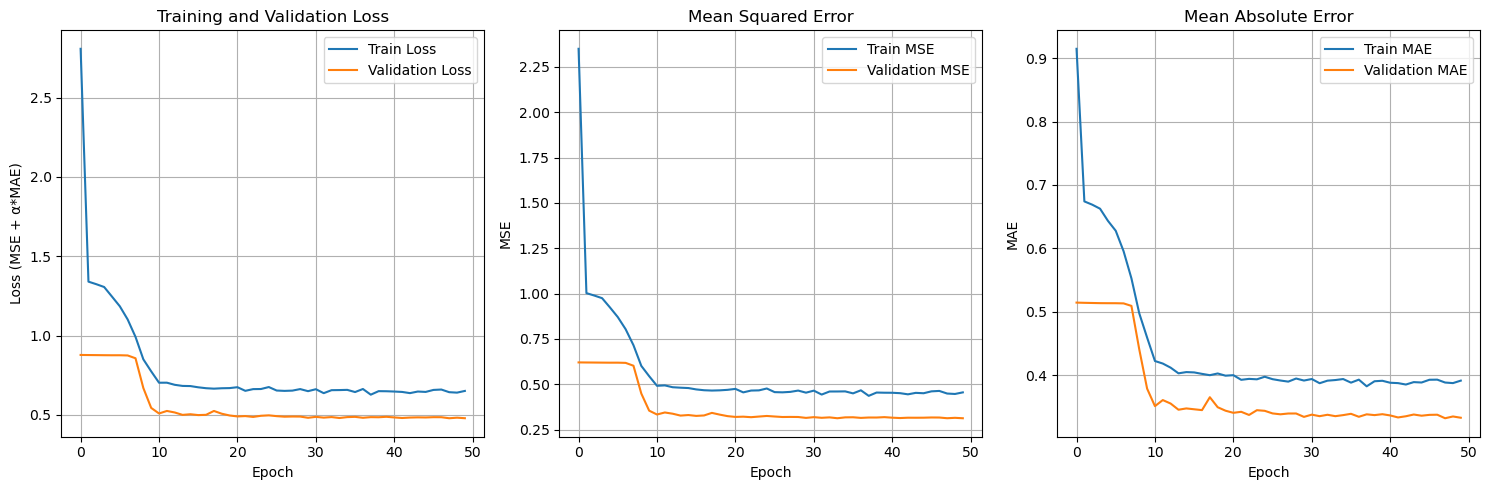

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE + α*MAE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_mse_list, label='Train MSE')
plt.plot(val_mse_list, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(train_mae_list, label='Train MAE')
plt.plot(val_mae_list, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [86]:
model.eval()
test_mse = 0.0
test_mae = 0.0
test_batches = 0

with torch.no_grad():
    for X_batch, y_batch in tqdm(test_loader, desc='Testing'):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        X_batch = X_batch.view(X_batch.size(0), -1)
        outputs = model(X_batch)
        
        test_mse += criterion_mse(outputs, y_batch).item()
        test_mae += criterion_mae(outputs, y_batch).item()
        test_batches += 1

test_mse /= test_batches
test_mae /= test_batches

print(f'  MSE: {test_mse:.6f}')
print(f'  MAE: {test_mae:.6f}')

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

  MSE: 0.260047
  MAE: 0.296195


In [ ]:
import os
from datetime import datetime

models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'mlp_model_{timestamp}.pth'
model_path = os.path.join(models_dir, model_filename)


torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_mse': train_mse_list,
    'val_mse': val_mse_list,
    'train_mae': train_mae_list,
    'val_mae': val_mae_list,
    'model_architecture': {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'output_size': output_size,
        'num_layers': num_layers
    },
    'hyperparameters': {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'alpha': alpha,
        'num_epochs': num_epochs
    },
    'final_test_metrics': {
        'test_mse': test_mse,
        'test_mae': test_mae
    }
}, model_path)

print(f'Модель сохранена: {model_path}')
print(f'Размер файла: {os.path.getsize(model_path) / (1024*1024):.2f} MB')


weights_filename = f'mlp_weights_{timestamp}.pth'
weights_path = os.path.join(models_dir, weights_filename)
torch.save(model.state_dict(), weights_path)
print(f'Веса модели сохранены: {weights_path}')
print(f'Размер файла с весами: {os.path.getsize(weights_path) / (1024*1024):.2f} MB')

Модель сохранена: saved_models\mlp_model_20260225_120302.pth
Размер файла: 262.09 MB
Веса модели сохранены: saved_models\mlp_weights_20260225_120302.pth
Размер файла с весами: 87.36 MB


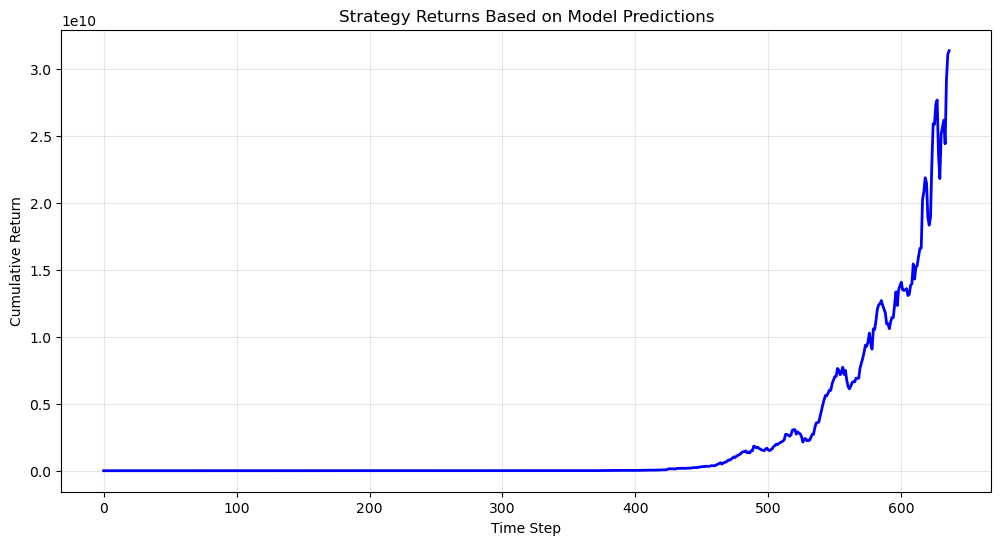

Total Return: 3136259096576.00%


In [85]:
def neutralize(predictions):
    """Обнуление средней прогноза (market-neutral)"""
    return predictions - np.mean(predictions, axis=1, keepdims=True)

def normalize(weights):
    """Нормализация весов портфеля"""
    abs_sum = np.sum(np.abs(weights), axis=1, keepdims=True)
    abs_sum[abs_sum == 0] = 1
    return weights / abs_sum

model.eval()
with torch.no_grad():
    if torch.is_tensor(x_test):
        x_test_tensor = x_test.to(device)
        y_test_np = y_test.cpu().numpy() if torch.is_tensor(y_test) else y_test
    else:
        x_test_tensor = torch.FloatTensor(x_test).to(device)
        y_test_np = y_test
    
    x_test_reshaped = x_test_tensor.reshape(x_test_tensor.size(0), -1)
    predictions = model(x_test_reshaped).cpu().numpy()

neutralized = neutralize(predictions)
weights = normalize(neutralized)
daily_returns = np.sum(weights * y_test_np, axis=1)
cumulative_returns = np.cumprod(1 + daily_returns)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, linewidth=2, color='blue')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Return')
plt.title('Strategy Returns Based on Model Predictions')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total Return: {(cumulative_returns[-1] - 1) * 100:.2f}%")
